# Introduction and Setup


100%|██████████| 170498071/170498071 [00:03<00:00, 52203330.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


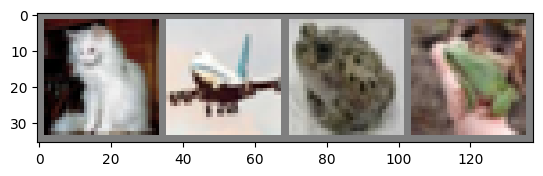

cat plane frog frog


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the CIFAR-10 dataset (you can also use Fashion MNIST if preferred)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Visualize some sample images from the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))


# Building and Training an MLP


In [ ]:
# Define an MLP architecture for CIFAR-10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Flatten the 32x32x3 image to a vector
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the MLP model, define the loss function and the optimizer
mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Training the MLP model
num_epochs = 10
for epoch in range(num_epochs):
    mlp_model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the MLP model on the test set
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

mlp_accuracy = evaluate(mlp_model, test_loader)
print(f'Accuracy of MLP on CIFAR-10 test images: {mlp_accuracy:.2f}%')

# Explain why MLP struggles with image data
print("Note: MLPs struggle with image data because they don't capture spatial patterns like CNNs.")


Epoch [1/10], Loss: 1.6615
Epoch [2/10], Loss: 1.4424
Epoch [3/10], Loss: 1.3300
Epoch [4/10], Loss: 1.2299
Epoch [5/10], Loss: 1.1488
Epoch [6/10], Loss: 1.0737
Epoch [7/10], Loss: 0.9960
Epoch [8/10], Loss: 0.9220
Epoch [9/10], Loss: 0.8539
Epoch [10/10], Loss: 0.7891
Accuracy of MLP on CIFAR-10 test images: 53.65%
Note: MLPs struggle with image data because they don't capture spatial patterns like CNNs.


# Building and Training a CNN


In [ ]:
# Define a simple CNN architecture for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels (RGB), 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 kernel
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model
cnn_model = SimpleCNN().to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the CNN model
for epoch in range(num_epochs):
    cnn_model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the CNN model on the test set
cnn_accuracy = evaluate(cnn_model, test_loader)
print(f'Accuracy of CNN on CIFAR-10 test images: {cnn_accuracy:.2f}%')

# Compare CNN vs. MLP performance
print(f'Comparison: MLP accuracy = {mlp_accuracy:.2f}%, CNN accuracy = {cnn_accuracy:.2f}%')


Epoch [1/10], Loss: 1.3259
Epoch [2/10], Loss: 0.9633
Epoch [3/10], Loss: 0.8133
Epoch [4/10], Loss: 0.6995
Epoch [5/10], Loss: 0.5974
Epoch [6/10], Loss: 0.5050
Epoch [7/10], Loss: 0.4211
Epoch [8/10], Loss: 0.3417
Epoch [9/10], Loss: 0.2689
Epoch [10/10], Loss: 0.2156
Accuracy of CNN on CIFAR-10 test images: 70.27%
Comparison: MLP accuracy = 53.65%, CNN accuracy = 70.27%


# Calculating Input Size for the Fully Connected Layer
To calculate the input size for the fully connected layer (self.fc1 = nn.Linear(64 * 8 * 8, 128)), you need to determine the dimensions of the output after the convolutional and pooling layers. Let’s walk through the calculation process step-by-step for the SimpleCNN architecture:

Input Image Size:

CIFAR-10 images are 32x32 pixels with 3 color channels (RGB). Thus, the input size is (3, 32, 32).

## First Convolutional Layer (self.conv1):

This layer has 32 filters (output channels) and a 3x3 kernel size, with padding of 1.

Formula for output size after a convolutional layer:

Output Height/Width =(Input Size−Kernel Size+2×Padding)/Stride + 1

Applying the formula:
Output Height= (32−3+2×1)/1+1= 32

The output size remains (32, 32), and the number of channels is now 32.

## First Pooling Layer (self.pool):

This layer uses 2x2 max pooling with a stride of 2.
Formula for output size after pooling:
Output Size = Input Size / Pool Size

Applying the formula:

Output Height/Width= 32/2 =16

The output size is now (32, 16, 16).

## Second Convolutional Layer (self.conv2):

This layer has 64 filters and uses a 3x3 kernel size with padding of 1.
Applying the convolution formula again:

Output Height = (16−3+2×1)/1+1=16

The output size remains (64, 16, 16), as the number of channels is now 64.

## Second Pooling Layer (self.pool):

This layer uses the same 2x2 max pooling with a stride of 2.
Applying the pooling formula:

Output Height/Width =16/2=8

The output size is now (64, 8, 8).

## Fully Connected Layer Input Size
After the convolutional and pooling layers, the output size is (64, 8, 8):

### 64: Number of channels (from the second convolutional layer).
### 8x8: Height and width of the feature map after the second pooling layer.

To connect this output to a fully connected layer (nn.Linear), we need to flatten the feature map. The number of input features is:

Input Features=64×8×8=4096

So, the input size for the fully connected layer is 4096

# Conclusion

* The MLP flattens the image data and processes it without considering the spatial structure, leading to poor performance on image datasets like CIFAR-10.
* The CNN utilizes convolutional layers that apply filters to the image, capturing spatial patterns and local features effectively. This structure allows CNNs to learn more meaningful features for tasks like image classification, resulting in higher accuracy.

In [ ]:
!pip install torchinfo

from torchinfo import summary

# Define your model (e.g., SimpleCNN)
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        return x

# Instantiate the model
model = SimpleCNN2()

summary(model, input_size=(1, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN2                               [1, 4096]                 --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
Total mult-adds (M): 5.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.08
Estimated Total Size (MB): 0.48

In PyTorch, x.view() is used to reshape a tensor without changing its data. It’s a very commonly used method when you need to adjust the dimensions of a tensor to match the expected input size of another layer, particularly when transitioning between convolutional layers and fully connected (linear) layers in a neural network.

The view() method returns a new tensor with the same data as the original tensor but with a different shape. The number of elements must remain the same after reshaping, so the total size of the tensor before and after the operation must match.

x = x.view(shape)

shape: A tuple that defines the new shape of the tensor. It must be compatible with the number of elements in the original tensor.
One of the dimensions can be -1, which tells PyTorch to automatically infer the size of that dimension based on the remaining dimensions and the number of elements in the tensor.

## Common Use Case: Flattening the Tensor

A common scenario where view() is used is in transitioning between convolutional layers and fully connected (linear) layers in a neural network. Convolutional layers output 4-dimensional tensors (batch size, channels, height, width), while fully connected layers expect a 2-dimensional input (batch size, features). You use view() to flatten the tensor before passing it to the fully connected layer.



In [ ]:
import torch
import torch.nn as nn

# Example tensor from a convolutional layer: batch size = 1, 64 channels, 8x8 feature map
x = torch.randn(1, 64, 8, 8)

# Flatten the tensor to (batch_size, all_features)
x = x.view(1, -1)  # Equivalent to x.view(1, 64 * 8 * 8)

# Output shape
print(x.shape)  # Output: torch.Size([1, 4096])

torch.Size([1, 4096])


# Regularization Techniques


In [ ]:
# Apply dropout to MLP
class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout layer
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Re-train the MLP with dropout and evaluate performance
mlp_dropout_model = MLPWithDropout().to(device)
optimizer = optim.Adam(mlp_dropout_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    mlp_dropout_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_dropout_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

mlp_dropout_accuracy = evaluate(mlp_dropout_model, test_loader)
print(f'MLP with Dropout Accuracy: {mlp_dropout_accuracy:.2f}%')


# MLP with Batch Normalization


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define an MLP with Batch Normalization
class MLPWithBatchNorm(nn.Module):
    def __init__(self):
        super(MLPWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.bn1 = nn.BatchNorm1d(512)  # BatchNorm after first fully connected layer
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)  # BatchNorm after second fully connected layer
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Instantiate the model, define loss function and optimizer
model_bn = MLPWithBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

# Training function


#Adding L2 Regularization


In [ ]:
# Define an MLP without batch normalization for comparison
class BasicMLP(nn.Module):
    def __init__(self):
        super(BasicMLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the basic MLP model
model_l2 = BasicMLP().to(device)

# Use L2 regularization by setting weight_decay parameter in the optimizer
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization

# Train the MLP with L2 regularization
train(model_l2, optimizer_l2)

# Evaluate the model
accuracy_l2 = evaluate(model_l2, test_loader)
print(f'MLP with L2 Regularization Accuracy: {accuracy_l2:.2f}%')


NameError: name 'train' is not defined

#Adding L1 Regularization


In [ ]:
# Define a function for L1 regularization
def l1_regularization(model, lambda_l1):
    l1_norm = sum(param.abs().sum() for param in model.parameters())
    return lambda_l1 * l1_norm

# Train function with L1 regularization
def train_with_l1(model, optimizer, lambda_l1, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Add L1 regularization to the loss
            l1_penalty = l1_regularization(model, lambda_l1)
            loss += l1_penalty

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Instantiate another model and optimizer
model_l1 = BasicMLP().to(device)
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.001)

# Train the MLP with L1 regularization
train_with_l1(model_l1, optimizer_l1, lambda_l1=0.001)

# Evaluate the model
accuracy_l1 = evaluate(model_l1, test_loader)
print(f'MLP with L1 Regularization Accuracy: {accuracy_l1:.2f}%')

